In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

## Update to use the annealed optimizer

In [31]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
dt = 0.2
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 750
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 500. * n_colloc * 3
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier,
        num_annealing_steps = 4,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-05, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 1125000.0}
Solving for data_weight = 1.0, colloc_weight = 9000.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 2.786e+06, gradnorm = 8.816e+06, alpha = 4.167, improvement_ratio = 0.8059
Iteration 1, loss = 5.579e+05, gradnorm = 3.976e+07, alpha = 4.167, improvement_ratio = 0.7999
Iteration 2, loss = 4.425e+05, gradnorm = 1.859e+07, alpha = 810.9, improvement_ratio = 0.2076
Iteration 3, loss = 6.502e+04, gradnorm = 4.526e+07, alpha = 83.33, improvement_ratio = 0.8542
Iteration 4, loss = 3.264e+03, gradnorm = 1.492e+07, alpha = 69.44, improvement_ratio = 0.9578
Iteration 5, loss = 1.917e+03, gradnorm = 4.697e+06, alpha = 156.3, improvement_ratio = 0.4891
Iteration 100, loss = 215.9, gradnorm = 1.997e+04, alpha = 0.5055, improvement_ratio = 0.8022
Line Search Failed!
Final Iteration Results
Iteration 169, loss = 191.0, gradnorm = 0.0008991, alpha = 901.5, improvement_ratio = -5.847e+03
Solving for data_weight = 1.0, colloc_weight = 45000.0 beta_reg = 0.004


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 197.8, gradnorm = 646.8, alpha = 85.43, improvement_ratio = 0.42
Iteration 1, loss = 196.9, gradnorm = 6.014e+04, alpha = 71.19, improvement_ratio = 0.8708
Iteration 2, loss = 196.4, gradnorm = 3.031e+04, alpha = 59.33, improvement_ratio = 0.8488
Iteration 3, loss = 196.0, gradnorm = 2.088e+04, alpha = 49.44, improvement_ratio = 0.8784
Iteration 4, loss = 195.7, gradnorm = 1.374e+04, alpha = 41.2, improvement_ratio = 0.8947
Iteration 5, loss = 195.5, gradnorm = 1.053e+04, alpha = 34.33, improvement_ratio = 0.901
Line Search Failed!
Final Iteration Results
Iteration 98, loss = 193.4, gradnorm = 0.002787, alpha = 95.53, improvement_ratio = -2.897e+04
Solving for data_weight = 1.0, colloc_weight = 225000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 197.7, gradnorm = 651.3, alpha = 85.43, improvement_ratio = 0.2378
Iteration 1, loss = 197.0, gradnorm = 1.732e+05, alpha = 71.19, improvement_ratio = 0.9036
Iteration 2, loss = 196.7, gradnorm = 2.954e+04, alpha = 59.33, improvement_ratio = 0.878
Iteration 3, loss = 196.5, gradnorm = 1.927e+04, alpha = 49.44, improvement_ratio = 0.9054
Iteration 4, loss = 196.2, gradnorm = 1.622e+04, alpha = 41.2, improvement_ratio = 0.916
Iteration 5, loss = 196.1, gradnorm = 1.574e+04, alpha = 34.33, improvement_ratio = 0.9128
Iteration 100, loss = 194.6, gradnorm = 0.01063, alpha = 0.01874, improvement_ratio = 158.2
Line Search Failed!
Final Iteration Results
Iteration 120, loss = 194.6, gradnorm = 0.01931, alpha = 2.771e+05, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 1125000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 195.9, gradnorm = 652.8, alpha = 128.1, improvement_ratio = 0.3623
Iteration 1, loss = 195.6, gradnorm = 3.027e+05, alpha = 83.33, improvement_ratio = 0.8367
Iteration 2, loss = 195.4, gradnorm = 9.322e+04, alpha = 69.44, improvement_ratio = 0.8281
Iteration 3, loss = 195.3, gradnorm = 1.293e+05, alpha = 57.87, improvement_ratio = 0.8678
Iteration 4, loss = 195.2, gradnorm = 1.039e+05, alpha = 48.23, improvement_ratio = 0.8979
Iteration 5, loss = 195.2, gradnorm = 7.554e+04, alpha = 40.19, improvement_ratio = 0.9172
Iteration 100, loss = 194.9, gradnorm = 0.07671, alpha = 0.01319, improvement_ratio = 0.2754
Line Search Failed!
Final Iteration Results
Iteration 106, loss = 194.9, gradnorm = 0.03517, alpha = 2e+04, improvement_ratio = -inf
Model after smooth warm start
(x)' = 21.567 1 + 2.141 x + 2.330 y + -3.061 z + -1.437 x^2 + 2.171 x y + -0.461 x z + -0.775 y^2 + 0.322 y z + 0.101 z^2
(y)' = -28.185 1 + 23.524 x + 4.760 y + 5.065 z + 2.769 x^2 + -3.026 x y + -0.76

In [32]:
model.opt_result[-1].history['objval'][-1]

[Array(223.89878783, dtype=float64)]

In [33]:
model.print()

(x)' = -1.612 1 + -9.711 x + 10.099 y
(y)' = 0.850 1 + 27.327 x + -1.078 y + -0.961 x z
(z)' = -2.687 z + 1.046 x y


In [34]:
model.print(expdata.true_coeff.T)

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [35]:
print(model.traj_model.kernel)

194.685 + 70.99Matern(5,0.14)


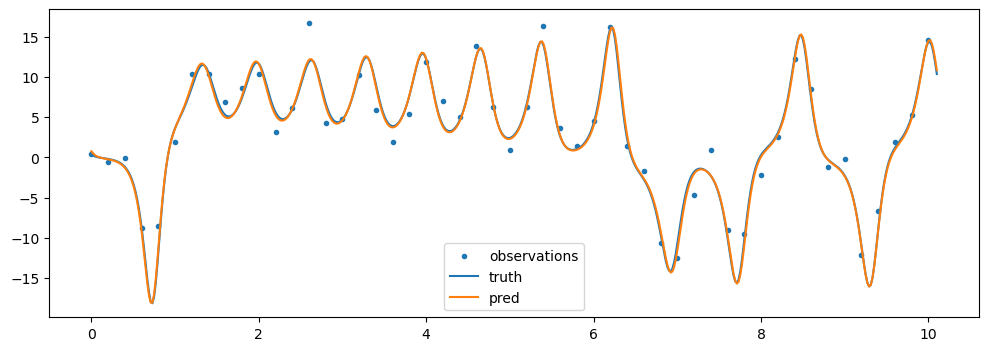

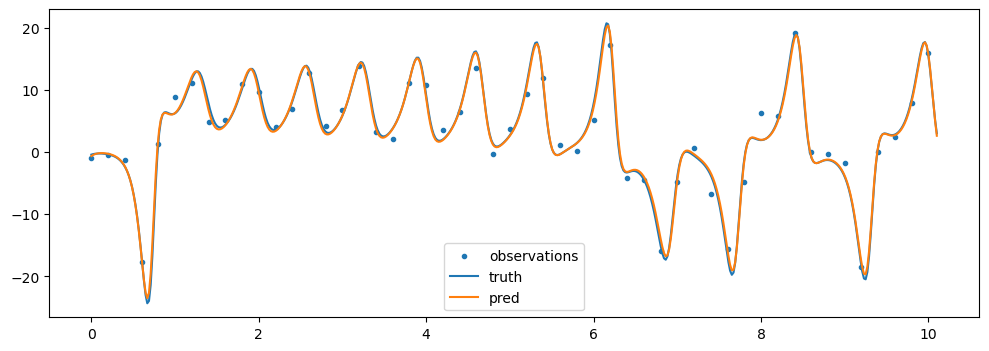

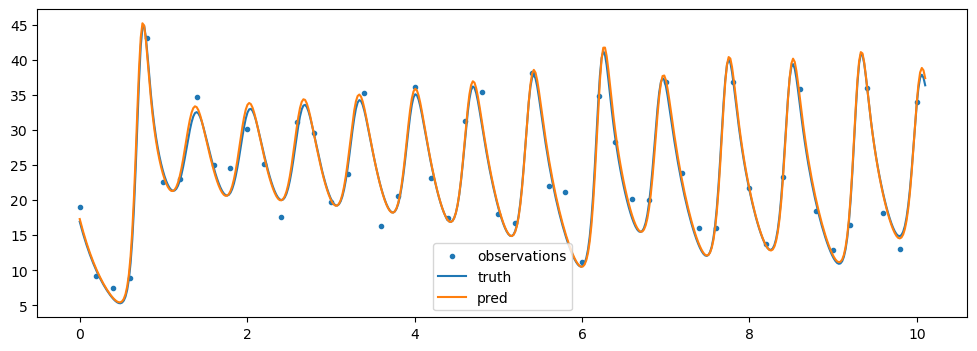

In [37]:
t_grid = jnp.linspace(0,t1,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


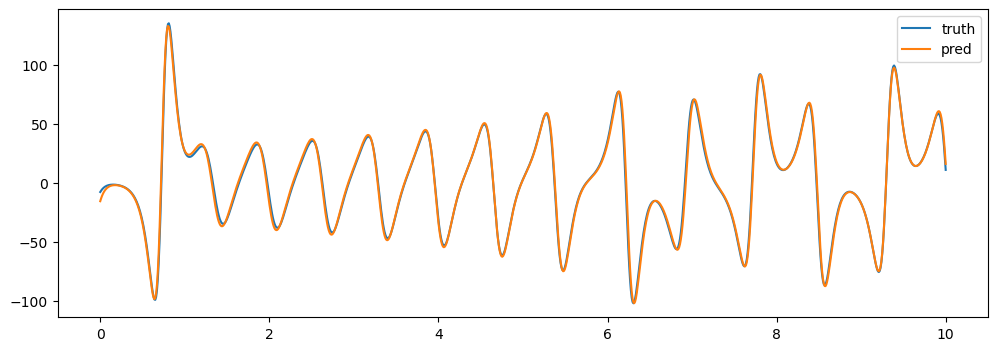

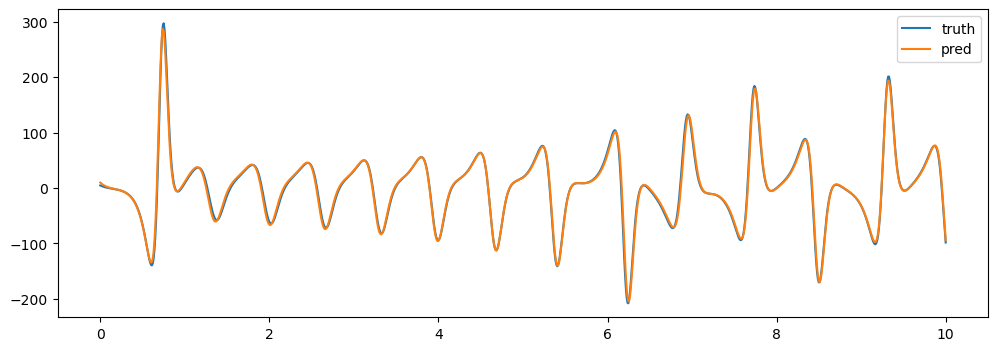

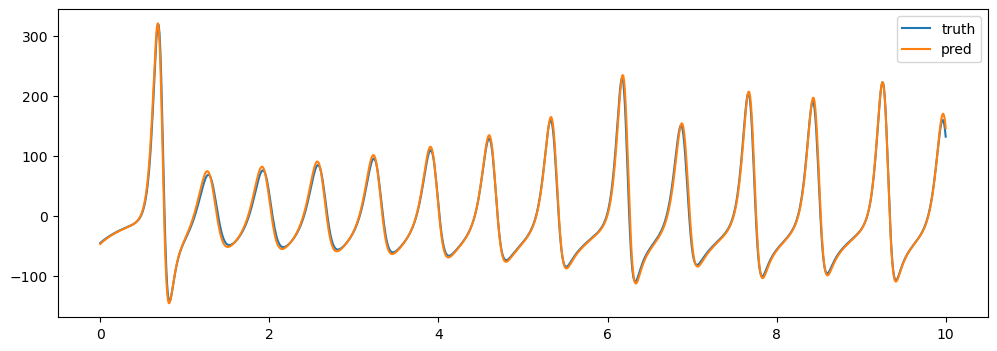

In [38]:
t_grid = jnp.linspace(0,10,1000)
dx_preds = model.traj_model.derivative(t_grid,model.z,1)

true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
true_dx = model.predict(true_states,expdata.true_coeff.T)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(t_grid,true_dx[:,dim],label = 'truth')
    plt.plot(t_grid,dx_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


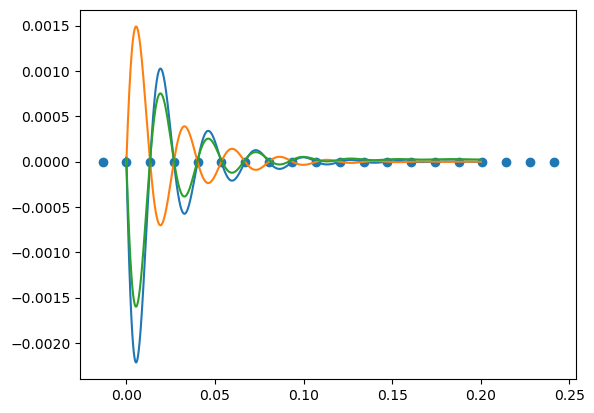

In [39]:
z = model.z
theta = model.theta
lower_t = 0.
end_t = 0.2
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

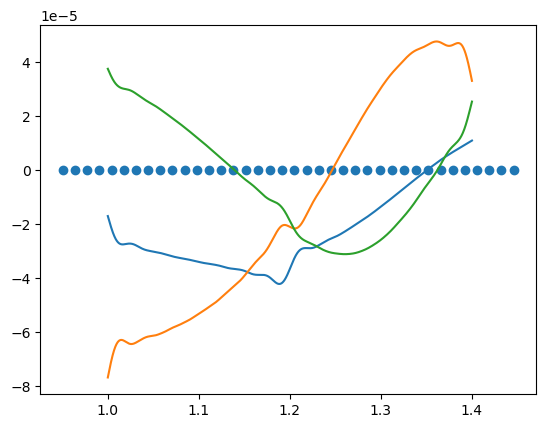

In [40]:
z = model.z
theta = model.theta
lower_t = 1.
end_t = 1.4
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

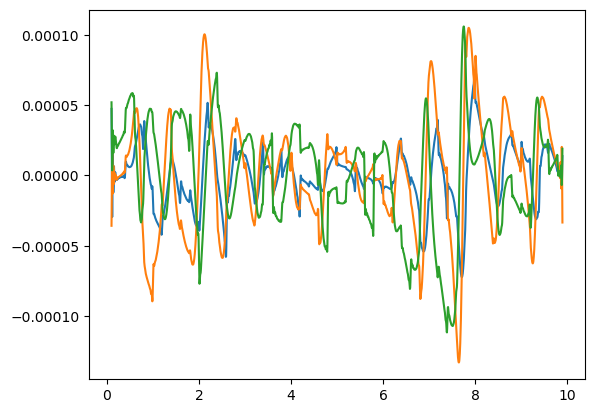

In [41]:
z = model.z
theta = model.theta
t_fine = jnp.linspace(0.1,9.9,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

In [42]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR,MIOSR
stlsq = STLSQ(threshold = 0.25,alpha =0.1,unbias = True)
optimizer = stlsq

optimizer = MIOSR(7,alpha = 0.)
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -9.761 x + 10.077 y
(y)' = 27.462 x + -1.097 y + -0.964 x z
(z)' = -2.687 z + 1.046 x y


In [47]:
import diffrax
def model_ode(t,x,args=None):
    return model.predict(x,model.theta)

term = diffrax.ODETerm(model_ode)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(ts = t_grid)
pidcontroller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.001, 
    y0=initial_state,
    saveat=save_at,
    max_steps = int(100*(t1-t0)/dt),
    args = None,
    stepsize_controller=pidcontroller
)

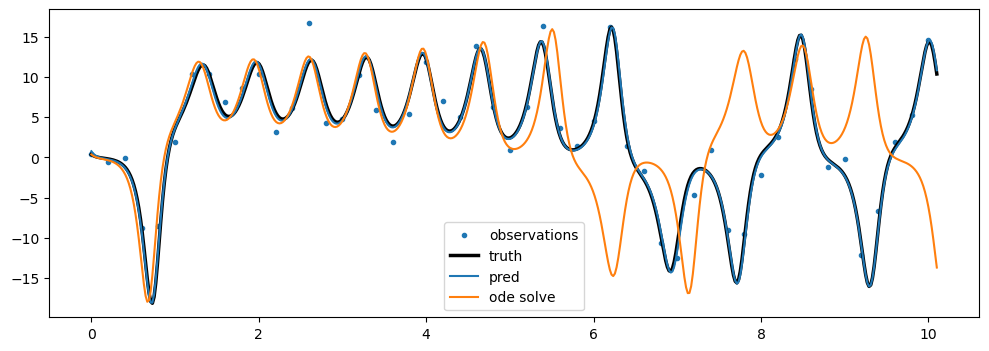

In [ ]:
t_grid = jnp.linspace(t0,t1,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black',lw = 2.5)
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.plot(t_grid,sol.ys[:,dim],label = 'ode solve')
    plt.legend()
    plt.show()
